# IHSG Analysis
This notebook does an analysis on IHSG closing price trends and see what kind of factors affect these trends. The IHSG (Indeks Harga Saham Gabungan), also known as the Jakarta Composite Index (JCI), is the main stock market index in Indonesia. It tracks the performance of all listed companies on the Indonesia Stock Exchange (IDX). IHSG is important as it shows the overall condition of the Indonesian stock market for foreign investors and thus would be the baseline for them whether to invest in Indonesia or not.

## Import Libraries

In [3]:
#Import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [4]:
#Import finance analysis libraries
import yfinance as yf
import requests

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
plt.style.available
plt.style.use('ggplot')

In [7]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

## Data Collection and Preparation
Collect data from Yahoo Finance API using the ticker "^JKSE". We will analyze using 5 years of daily data, starting from 2019 to 2024.

In [9]:
#We'll get the data period for max years because we want to calculate the moving average
jkse = yf.Ticker("^JKSE")
ihsg_data = jkse.history(period='max', interval="1d")
ihsg_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1990-04-06 00:00:00+07:00,641.244019,641.244019,641.244019,641.244019,0,0.0,0.0
1990-04-09 00:00:00+07:00,633.457336,633.457336,633.457336,633.457336,0,0.0,0.0
1990-04-10 00:00:00+07:00,632.061340,632.061340,632.061340,632.061340,0,0.0,0.0
1990-04-11 00:00:00+07:00,634.668274,634.668274,634.668274,634.668274,0,0.0,0.0
1990-04-12 00:00:00+07:00,639.589111,639.589111,639.589111,639.589111,0,0.0,0.0


In [10]:
ihsg_data.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

In [11]:
ihsg_data.duplicated().sum()

17

In [12]:
ihsg_data.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [13]:
ihsg_data.index = pd.to_datetime(ihsg_data.index, format='%Y-%m-%d')
ihsg_data

,Open,High,Low,Close,Volume
Date,,,,,
1990-04-06 00:00:00+07:00,641.244019,641.244019,641.244019,641.244019,0
1990-04-09 00:00:00+07:00,633.457336,633.457336,633.457336,633.457336,0
1990-04-10 00:00:00+07:00,632.061340,632.061340,632.061340,632.061340,0
1990-04-11 00:00:00+07:00,634.668274,634.668274,634.668274,634.668274,0
1990-04-12 00:00:00+07:00,639.589111,639.589111,639.589111,639.589111,0
...,...,...,...,...,...
2024-10-21 00:00:00+07:00,7780.245117,7795.086914,7739.887207,7772.596191,246855900
2024-10-22 00:00:00+07:00,7752.383789,7801.403809,7731.960938,7788.982910,286785700
2024-10-23 00:00:00+07:00,7774.009766,7805.916992,7761.251953,7787.564941,269650200


In [14]:
#Add a feature of Price Changes in percentage
ihsg_data['CloseChanges'] = ihsg_data['Close'].pct_change()
ihsg_data.head()

,Open,High,Low,Close,Volume,CloseChanges
Date,,,,,,
1990-04-06 00:00:00+07:00,641.244019,641.244019,641.244019,641.244019,0,NaN
1990-04-09 00:00:00+07:00,633.457336,633.457336,633.457336,633.457336,0,-0.012143
1990-04-10 00:00:00+07:00,632.061340,632.061340,632.061340,632.061340,0,-0.002204
1990-04-11 00:00:00+07:00,634.668274,634.668274,634.668274,634.668274,0,0.004124
1990-04-12 00:00:00+07:00,639.589111,639.589111,639.589111,639.589111,0,0.007753


In [15]:
#Add moving average
ihsg_data['MA20'] = ihsg_data['Close'].rolling(20).mean()
ihsg_data['MA30'] = ihsg_data['Close'].rolling(30).mean()
ihsg_data['MA50'] = ihsg_data['Close'].rolling(50).mean()
ihsg_data['MA100'] = ihsg_data['Close'].rolling(100).mean()
ihsg_data['MA200'] = ihsg_data['Close'].rolling(200).mean()

In [16]:
ihsg_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8425 entries, 1990-04-06 00:00:00+07:00 to 2024-10-25 00:00:00+07:00
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          8425 non-null   float64
 1   High          8425 non-null   float64
 2   Low           8425 non-null   float64
 3   Close         8425 non-null   float64
 4   Volume        8425 non-null   int64  
 5   CloseChanges  8424 non-null   float64
 6   MA20          8406 non-null   float64
 7   MA30          8396 non-null   float64
 8   MA50          8376 non-null   float64
 9   MA100         8326 non-null   float64
 10  MA200         8226 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 789.8 KB


In [17]:
ihsg_data.index = pd.to_datetime(ihsg_data.index)

In [18]:
#Now let's get only data from 2018 until 2024

ihsg_data = ihsg_data[ihsg_data.index.year >= 2018]

### Don't Ask for request
To prevent requesting with the API over and over again, we will download the data and store it in our local file. Then we will import it when needed

In [20]:
#ihsg_data.to_csv("stock_data.csv")

In [21]:
#ihsg_data = pd.read_csv("stock_data.csv").set_index('Date')

## Exploratory Data Analysis
Plotting the daily Closing Price changes along with other features that might correlate with the Closing Price to view any trends

### IHSG Closing Price and volume traded

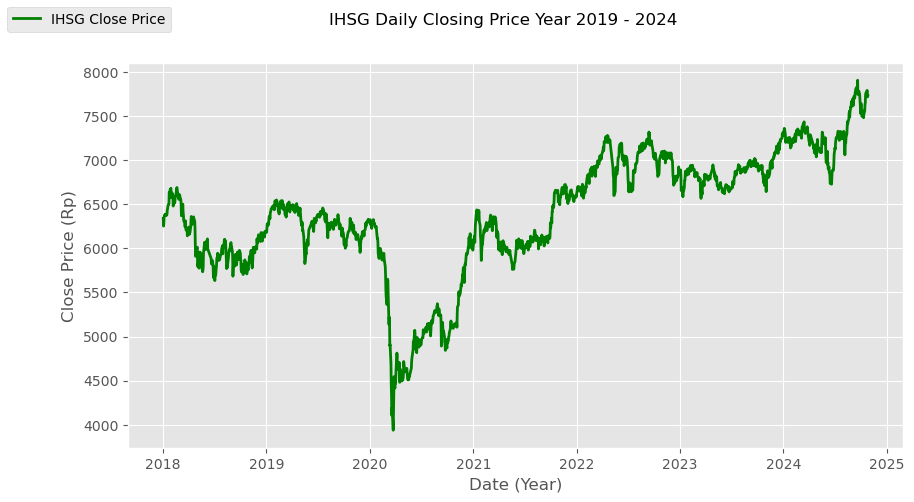

In [24]:
#Plot IHSG Closing Price to view it's trend

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(ihsg_data.index, ihsg_data['Close'], color="green", linewidth=2, label='IHSG Close Price')
ax.set_xlabel('Date (Year)')
ax.set_ylabel('Close Price (Rp)')

fig.suptitle("IHSG Daily Closing Price Year 2019 - 2024")
fig.legend(loc='upper left')

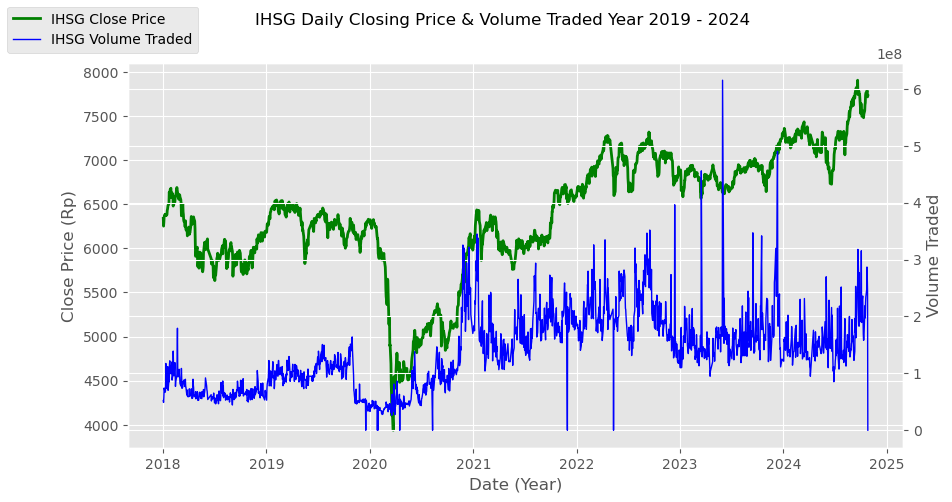

In [25]:
#Plot IHSG Closing Price and volume traded to view it's trend

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(ihsg_data.index, ihsg_data['Close'], color="green", linewidth=2, label='IHSG Close Price')
ax1.set_xlabel('Date (Year)')
ax1.set_ylabel('Close Price (Rp)')

ax2 = ax1.twinx()
ax2.plot(ihsg_data.index, ihsg_data['Volume'], color="blue", linewidth=1, label='IHSG Volume Traded')
ax2.set_ylabel('Volume Traded')

fig.suptitle("IHSG Daily Closing Price & Volume Traded Year 2019 - 2024")
fig.legend(loc='upper left')

In [26]:
#There are some inputs where there were no trades made (volume = 0) let's drop those
ihsg_data = ihsg_data[ihsg_data['Volume'] != 0]

<b> IHSG Daily Closing Price Year 2019 - 2024 </b>  
From the graph above, we could see that the IHSG closing price experienced a significant drop during the beginning of 2020. This occurance happens the same time Indonesia received its first Covid-19 patient, which was during March 2020. However, the volume traded was not that big. We can see that before the drop of the price, the volume traded had a significant drop during the end of 2019, when the world received the first Covid-19 patient and several countries has gone lockdown. This shows a correlation between the stock market and the market activities or condition. Let's take a closer look!

In [28]:
pysqldf("""
select Date, Close, CloseChanges
from ihsg_data
where CloseChanges not null
order by Close
limit 1""")

,Date,Close,CloseChanges
0,2020-03-24 00:00:00.000000,3937.63208,-0.013005


The Lowest Low Closing Price during these 5 years period happened on March 24th, 2020.

In [30]:
pysqldf("""
select Date, Close, CloseChanges
from ihsg_data
where CloseChanges not null
order by Close desc
limit 1""")

,Date,Close,CloseChanges
0,2024-09-19 00:00:00.000000,7905.390137,0.00974


The Highest High Closing Price during these 5 years period happened on September 9th, 2024. This highest high indicates that the IHSG number is growing strongly for the past year.

### IHSG and Percentage Change

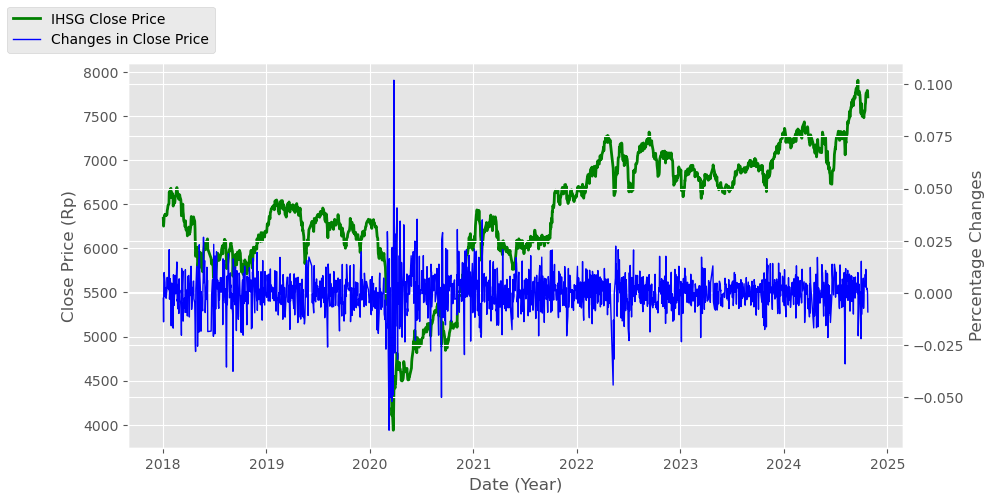

In [33]:
#Plot IHSG and its percentage change

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(ihsg_data.index, ihsg_data['Close'], color="green", linewidth=2, label='IHSG Close Price')
ax1.set_xlabel('Date (Year)')
ax1.set_ylabel('Close Price (Rp)')

ax2 = ax1.twinx()
ax2.plot(ihsg_data.index, ihsg_data['CloseChanges'], color="blue", linewidth=1, label='Changes in Close Price')
ax2.set_ylabel('Percentage Changes')

fig.legend(loc='upper left')

<b>IHSG Closing Price and Daily Percentage Change</b>  
We see the percentage changes are mostly stable around -2.5% and 2.5%. However, we can see there's a big spike reaching 10% and a big slope reaching -6%. Let's see when did these maximas occured during this period! We'll use SQL for this task.

In [35]:
#Get the biggest positive percentage change
pysqldf("""
select Date, Close, CloseChanges
from ihsg_data
where CloseChanges not null
order by CloseChanges desc
limit 1""")

,Date,Close,CloseChanges
0,2020-03-26 00:00:00.000000,4338.903809,0.101907


In [36]:
#Get the biggest negative percentage change
pysqldf("""
select Date, Close, CloseChanges
from ihsg_data
where CloseChanges not null
and CloseChanges < 0
order by CloseChanges
limit 1""")

,Date,Close,CloseChanges
0,2020-03-09 00:00:00.000000,5136.809082,-0.065787


The biggest positive percentage change in IHSG happened on March 26th, 2020 on 10.19%. While, the biggest negative percentage change in IHSG happened on <b>March 9th, 2020</b> on -6.58%.

<b>Monthly Movement</b>  
Daily movement is not very readable. To get a better understanding, let's view it by month.

In [39]:
ihsg_monthly = ihsg_data.resample('M').mean()

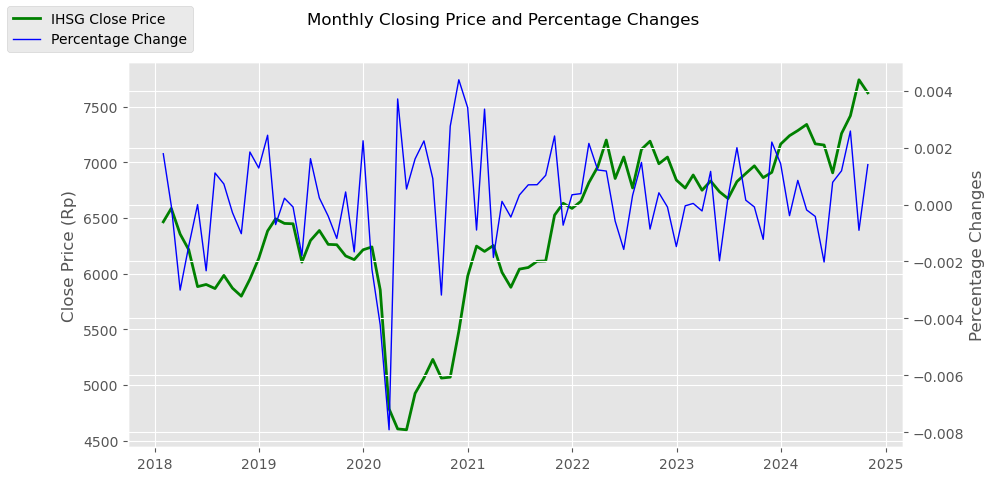

In [40]:
#Plot Monthly IHSG
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(ihsg_monthly.index, ihsg_monthly['Close'], color="green", linewidth=2, label='IHSG Close Price')
ax1.set_ylabel('Close Price (Rp)')

ax2 = ax1.twinx()
ax2.plot(ihsg_monthly.index, ihsg_monthly['CloseChanges'], color="blue", linewidth=1, label='Percentage Change')
ax2.set_ylabel('Percentage Changes')

fig.suptitle('Monthly Closing Price and Percentage Changes')
fig.legend(loc='upper left')

In [41]:
#Get the biggest positive percentage change
max_pct_monthly = pysqldf("""
select *
from ihsg_monthly
where CloseChanges not null
order by CloseChanges desc
limit 1""")

print(f"The biggest positive percentage change happened on {pd.to_datetime(max_pct_monthly['Date'].values).strftime("%B %d, %Y").values} with percentage change reaching {np.round(max_pct_monthly['CloseChanges'].values, 4)} and Close Price at {np.round(max_pct_monthly['Close'].values)}")

The biggest positive percentage change happened on ['November 30, 2020'] with percentage change reaching [0.0044] and Close Price at [5484.]


In [42]:
#Get the biggest negative percentage change
min_pct_monthly = pysqldf("""
select *
from ihsg_monthly
where CloseChanges not null
and CloseChanges < 0
order by CloseChanges
limit 1""")

print(f"The biggest negative percentage change happened on {pd.to_datetime(min_pct_monthly['Date'].values).strftime("%B %d, %Y").values} with percentage change reaching {np.round(min_pct_monthly['CloseChanges'].values, 4)} and Close Price at {np.round(min_pct_monthly['Close'].values)}")

The biggest negative percentage change happened on ['March 31, 2020'] with percentage change reaching [-0.0079] and Close Price at [4787.]


On monthly data, the biggest positive increase in IHSG happened on November 2020, while the biggest negative percentage change in IHSG happened on March 2020. 

<b>March 2020 Plot</b>  
Since March 2020 seem to have the biggest drop and increase than any other period by daily, we will look deeper into it!

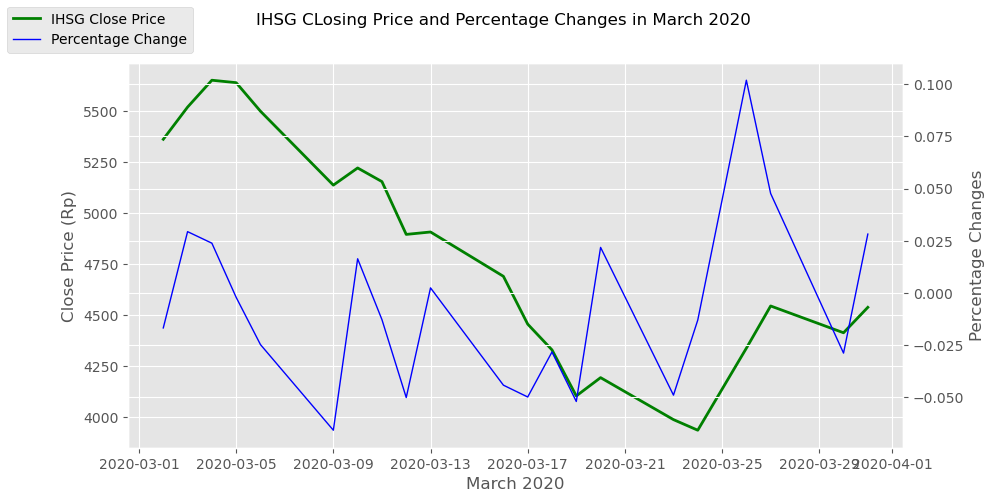

In [45]:
#Plot March 2020 Data
ihsg_mar2020 = ihsg_data[(ihsg_data.index.month == 3) & (ihsg_data.index.year == 2020)]

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(ihsg_mar2020.index, ihsg_mar2020['Close'], color="green", linewidth=2, label='IHSG Close Price')
ax1.set_xlabel('March 2020')
ax1.set_ylabel('Close Price (Rp)')

ax2 = ax1.twinx()
ax2.plot(ihsg_mar2020.index, ihsg_mar2020['CloseChanges'], color="blue", linewidth=1, label='Percentage Change')
ax2.set_ylabel('Percentage Changes')

fig.suptitle("IHSG CLosing Price and Percentage Changes in March 2020")
fig.legend(loc='upper left')

<b>March 2020 Analysis</b>  
On March 9th, the cases of COVID-19 began to spur in Indonesia, even though the numbers are still low, people became uncertain with the situation and possibly keeping their cash for emergencies. Foreign investors are also taking their investments out of Indonesia.

### Monthly Trend by Year

Now, we are going to find out trends of IHSG closing price in each year. To do this, we will group IHSG into each year and plot them accordingly for daily and monthly. 

#### Daily Yearly Trend

In [50]:
for year in ihsg_data['year'].unique():
    globals()[f"ihsg_data_{year}"] = ihsg_data[ihsg_data['year'] == year]
    print(f"The shape for IHSG data year {year}: ", globals()[f"ihsg_data_{year}"].shape)

KeyError: 'year'

In [ ]:
import matplotlib.dates as mdates
fig, axs = plt.subplots(3, 2, figsize = (20, 15), layout="constrained")
fig.suptitle("IHSG Daily Close Prices by Years")

year = 2019

for row in range(3):
    for col in range(2):
        ihsg_data_x = globals()[f'ihsg_data_{year}']
        axs[row, col].plot(ihsg_data_x.index, ihsg_data_x["Close"])
        axs[row, col].set_title(f'Close Prices {year}')
        year += 1
for ax in axs.flat:
    ax.set(xlabel='Daily', ylabel='Close Price')

plt.show()

#### Monthly Trend by Year

In [ ]:
for year in ihsg_data['year'].unique():
    ihsg_data_x = globals()[f'ihsg_data_{year}']
    ihsg_data_x = ihsg_data_x.groupby(['month']).mean()
    ihsg_data_x = ihsg_data_x.drop(columns=['year'])
    globals()[f'ihsg_data_{year}'] = ihsg_data_x

In [ ]:
fig, axs = plt.subplots(3, 2, figsize = (20, 15), layout="constrained")
fig.suptitle("IHSG Monthly Close Prices by Years")

year = 2019

for row in range(3):
    for col in range(2):
        ihsg_data_x = globals()[f'ihsg_data_{year}']
        axs[row, col].plot(ihsg_data_x.index, ihsg_data_x["Close"])
        axs[row, col].set_title(f'Close Prices {year}')
        year += 1
for ax in axs.flat:
    ax.set(xlabel='Monthly', ylabel='Close Price')

plt.show()

From the yearly graph, we could see that there is a similar trends in each year, which is a decline around the second quarter (Month 4th and 6th). The first quarter normally shows an uptrend every year, except for the year 2020. This happens due to the outbreak of Covid-19, which led people to keep their cash in for emergencies and investors are in a wait-and-see state, since a crisis normally brings the economy down leading to high inflation. This crisis led to IHSG to reach an all time low for these periods of years, reaching (average) Rp4,600. Not too long, the market started to regain strength and recovers slowly, leading to an upward trend and reaching an all time high of (average) Rp7,700 on September 2024. 

## Merging External Data

From our EDA, it is proven that there are some cyclical trends in IHSG closing price. It also implies there are some external factors that affects the price of IHSG, one of which are world crisis, such as COVID-19. World crisis does not directly affect IHSG. It is because a change in macroeconomic factors reacting to those crisis. Therefore, to get a better understanding, let's see what kind of factors affect IHSG more. There are multiple researches that shows the Stock Index are affected by macroeconomics factors, both internal and external.  

Most researches suggests these macroeconomic variables to affect the IHSG Price:
- Internal factors: Exchange Rate, BI Rate, Inflation Rate
- External Factors: Dow Jones Index (DJIA), Straits times index (STI), Gold Price, and Crude Oil Prices.

In the next section, we will try to get these data to understand the movement of IHSG.

### USD Exchange Rate
The USD/IDR Exchange rate holds a significant factor, since it valuates the price of IDR towards USD. It is also a factor for foreign investor to valuate their investments in Indonesia. To get this data, we downloaded it through the BI Webpage: https://www.bi.go.id/id/statistik/informasi-kurs/transaksi-bi/Default.aspx

In [115]:
usd_kurs = pd.read_excel('kurs_transaksi_usd.xlsx')
usd_kurs = usd_kurs.drop(columns=['NO', 'Nilai'])

In [117]:
#The Date column is still an object, we should change that
usd_kurs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425 entries, 0 to 1424
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Kurs Jual  1425 non-null   float64
 1   Kurs Beli  1425 non-null   float64
 2   Tanggal    1425 non-null   object 
dtypes: float64(2), object(1)
memory usage: 33.5+ KB


In [119]:
#Rename Column name
usd_kurs.columns = ['Sell_Rate', 'Buy_Rate', 'Date']

In [121]:
usd_kurs['Date'] = pd.to_datetime(usd_kurs['Date'])
usd_kurs = usd_kurs.sort_values(by=['Date'], ascending=True)

In [ ]:
usd_kurs

### BI Rate
BI Rate is the Central Bank of Indonesia's Interest Rate. This hugely affects the stock market because

In [123]:
bi_rate = pd.read_excel("bi_rate.xlsx", sheet_name="bi_rate")
bi_rate['Date'] = pd.to_datetime(bi_rate['Date'])

In [125]:
bi_rate.head(5)

,Date,BI-7Day-RR
0,2024-10-16,0.0600
1,2024-09-18,0.0600
2,2024-08-21,0.0625
3,2024-07-17,0.0625
4,2024-06-20,0.0625


In [127]:
bi_rate['month'] = bi_rate['Date'].dt.month
bi_rate['year'] = bi_rate['Date'].dt.year

### Inflation Rate
Inflation Rate affects Stock Price because it is strongly correlated with people's sentiment.

In [129]:
inflation_rate = pd.read_excel("inflation_rate.xlsx", sheet_name="inflation_fix")
inflation_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       69 non-null     object 
 1   Inflation  69 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.2+ KB


The Date from Inflation Rate File is read as an object type. Let's change it into datetime.

In [131]:
inflation_rate['Date'] = pd.to_datetime(inflation_rate['Date'])
inflation_rate['Date'] = pd.to_datetime(inflation_rate['Date'], format="%Y-%m-%d")
inflation_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       69 non-null     datetime64[ns]
 1   Inflation  69 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.2 KB


In [133]:
inflation_rate['month'] = inflation_rate['Date'].dt.month
inflation_rate['year'] = inflation_rate['Date'].dt.year

inflation_rate.head()

,Date,Inflation,month,year
0,2024-09-01,0.0184,9,2024
1,2024-08-01,0.0212,8,2024
2,2024-07-01,0.0213,7,2024
3,2024-06-01,0.0251,6,2024
4,2024-05-01,0.0284,5,2024


In [ ]:
inflation_rate.tail()

### Combine Internal Factors
Since BI Rate and Inflation Rate is announced once a month, we need to merge them into USD Exchange Rate which is announced everyday. To do this we will merge datasets and fill the null values with the appropriate scores.

In [135]:
internal = pd.merge(
    usd_kurs,
    bi_rate['BI-7Day-RR'],
    left_on=[usd_kurs['Date']],
    right_on=[bi_rate['Date']],
    how="left",
    suffixes=("_kurs", "_rate")
).drop(['key_0'], axis=1)

In [137]:
#Fill in BI Rate after the announced date
internal.fillna(method="ffill", inplace=True)

In [139]:
#Fill in BI Rate for the first 17 days in January since it still has the same value
internal.fillna(method="bfill", inplace=True)

In [141]:
'''Since inflation is announced every month, we need to fill in every day as the value of inflation in each month. 
To do this, we join both dataframe using the year and month. Lastly, for October 2024, we interpolate to fill in.
'''
internal = pd.merge(
    internal,
    inflation_rate['Inflation'],
    left_on=[internal['Date'].dt.year, internal['Date'].dt.month],
    right_on=[inflation_rate['year'], inflation_rate['month']],
    how="left"
).drop(['key_0', 'key_1'], axis=1).interpolate()

In [ ]:
internal

In [143]:
ihsg_data.reset_index(inplace=True)
ihsg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1645 entries, 0 to 1644
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype                       
---  ------        --------------  -----                       
 0   Date          1645 non-null   datetime64[ns, Asia/Jakarta]
 1   Open          1645 non-null   float64                     
 2   High          1645 non-null   float64                     
 3   Low           1645 non-null   float64                     
 4   Close         1645 non-null   float64                     
 5   Volume        1645 non-null   int64                       
 6   CloseChanges  1645 non-null   float64                     
 7   MA20          1645 non-null   float64                     
 8   MA30          1645 non-null   float64                     
 9   MA50          1645 non-null   float64                     
 10  MA100         1645 non-null   float64                     
 11  MA200         1645 non-null   float64                   

In [145]:
from datetime import datetime
ihsg_data['Date'] = pd.to_datetime(ihsg_data['Date']).dt.date
ihsg_data['Date'] = pd.to_datetime(ihsg_data['Date'])

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(internal['Date'], internal['Sell_Rate'], color="green", linewidth=2, label='Sell Exchange Rate')
ax1.set_xlabel('Date (Year)')
ax1.set_ylabel('USD Exc Rate')
ax1.plot(internal['Date'], internal['Buy_Rate'], color="blue", linewidth=1, label='Buy Exchange Rate')

ax3 = ax1.twinx()
ax3.plot(internal['Date'], internal['BI-7Day-RR'], color="red", linewidth=1, label='BI Rate')
ax3.plot(internal['Date'], internal['Inflation'], color="orange", linewidth=1, label='Inflation Rate')
ax3.set_ylabel('Rate')

fig.suptitle("Internal Macroeconomic Factors")
fig.legend(loc='upper left')

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(internal['Date'], internal['Sell_Rate'], color="green", linewidth=2, label='Sell Exchange Rate')
ax1.set_xlabel('Date (Year)')
ax1.set_ylabel('USD Exc Rate')
ax1.plot(internal['Date'], internal['Buy_Rate'], color="blue", linewidth=1, label='Buy Exchange Rate')

ax3 = ax1.twinx()
ax3.plot(ihsg_data['Date'], ihsg_data['Close'], color="orange", linewidth=1, label='IDX Composite Closing Price')
ax3.set_ylabel('Price (Rp)')

fig.suptitle("Exchange Rate over IDX Composite Closing Price")
fig.legend(loc='upper left')

The plot shows there is an inverse relationship between Exchange Rate and the IDX Closing Price. 

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(internal['Date'], internal['BI-7Day-RR'], color="green", linewidth=1, label='BI Rate')
ax1.plot(internal['Date'], internal['Inflation'], color="blue", linewidth=1, label='Inflation Rate')
ax1.set_xlabel('Date (Year)')
ax1.set_ylabel('Rate')


ax3 = ax1.twinx()
ax3.plot(ihsg_data['Date'], ihsg_data['Close'], color="orange", linewidth=1, label='IDX Composite Closing Price')
ax3.set_ylabel('Price (Rp)')

fig.suptitle("Macro Rate over IDX Composite Closing Price")
fig.legend(loc='upper left')

In [155]:
ihsg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1645 entries, 0 to 1644
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          1645 non-null   datetime64[ns]
 1   Open          1645 non-null   float64       
 2   High          1645 non-null   float64       
 3   Low           1645 non-null   float64       
 4   Close         1645 non-null   float64       
 5   Volume        1645 non-null   int64         
 6   CloseChanges  1645 non-null   float64       
 7   MA20          1645 non-null   float64       
 8   MA30          1645 non-null   float64       
 9   MA50          1645 non-null   float64       
 10  MA100         1645 non-null   float64       
 11  MA200         1645 non-null   float64       
dtypes: datetime64[ns](1), float64(10), int64(1)
memory usage: 154.3 KB


In [ ]:
internal.info()

In [157]:
ihsg_data_temp = ihsg_data[['Date','Close', 'MA20', 'MA30', 'MA50', 'MA100', 'MA200']]
#ihsg_data_temp.reset_index(inplace=True)

In [159]:
ihsg_data_temp

,Date,Close,MA20,MA30,MA50,MA100,MA200
0,2018-01-02,6339.237793,6123.620264,6098.608789,6062.400928,5971.041499,5824.431804
1,2018-01-03,6251.479004,6138.587305,6105.267025,6068.839531,5975.450659,5828.873918
2,2018-01-04,6292.320801,6153.293604,6113.234977,6075.685430,5980.133799,5833.294253
3,2018-01-05,6353.737793,6170.956787,6123.964176,6083.718662,5985.411719,5838.106868
4,2018-01-08,6385.403809,6188.451587,6134.484798,6090.918057,5991.604375,5842.984802
...,...,...,...,...,...,...,...
1640,2024-10-18,7760.060059,7620.184424,7675.673633,7617.475156,7364.621909,7302.159980
1641,2024-10-21,7772.596191,7620.027686,7677.365299,7627.787158,7370.945581,7305.646257
1642,2024-10-22,7788.982910,7620.552271,7680.240104,7637.614316,7378.493989,7308.711091
1643,2024-10-23,7787.564941,7622.885425,7681.112663,7646.232852,7386.662280,7311.693977


In [161]:
ihsg_data_temp['Date'] = ihsg_data_temp['Date'].dt.date
ihsg_data_temp['Date'] = pd.to_datetime(ihsg_data_temp['Date'])
ihsg_data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1645 entries, 0 to 1644
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1645 non-null   datetime64[ns]
 1   Close   1645 non-null   float64       
 2   MA20    1645 non-null   float64       
 3   MA30    1645 non-null   float64       
 4   MA50    1645 non-null   float64       
 5   MA100   1645 non-null   float64       
 6   MA200   1645 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 90.1 KB


In [163]:
merged = pd.merge(
    internal,
    ihsg_data_temp[['Close', 'MA20', 'MA30', 'MA50', 'MA100', 'MA200']],
    left_on=[internal['Date']],
    right_on=[ihsg_data_temp['Date']],
    how="inner"
).drop(columns=['key_0'], axis=1)

In [165]:
merged.set_index('Date', inplace=True)

In [167]:
merged_corr = merged.corr()

<Axes: >

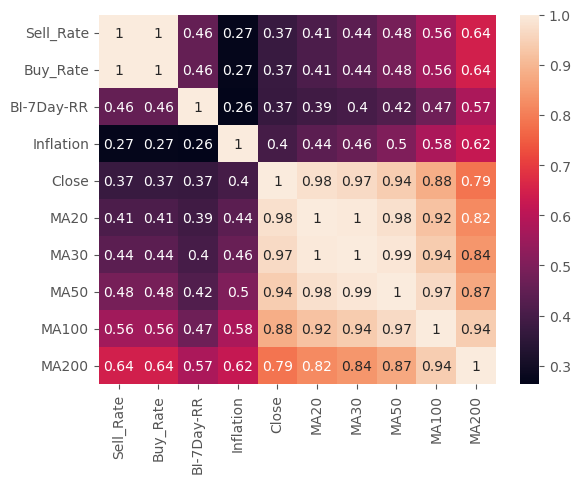

In [169]:
sns.heatmap(merged_corr, annot=True)

Every factor shows a positive and strong correlation with Closing Price, but it could lead to autocorrelation

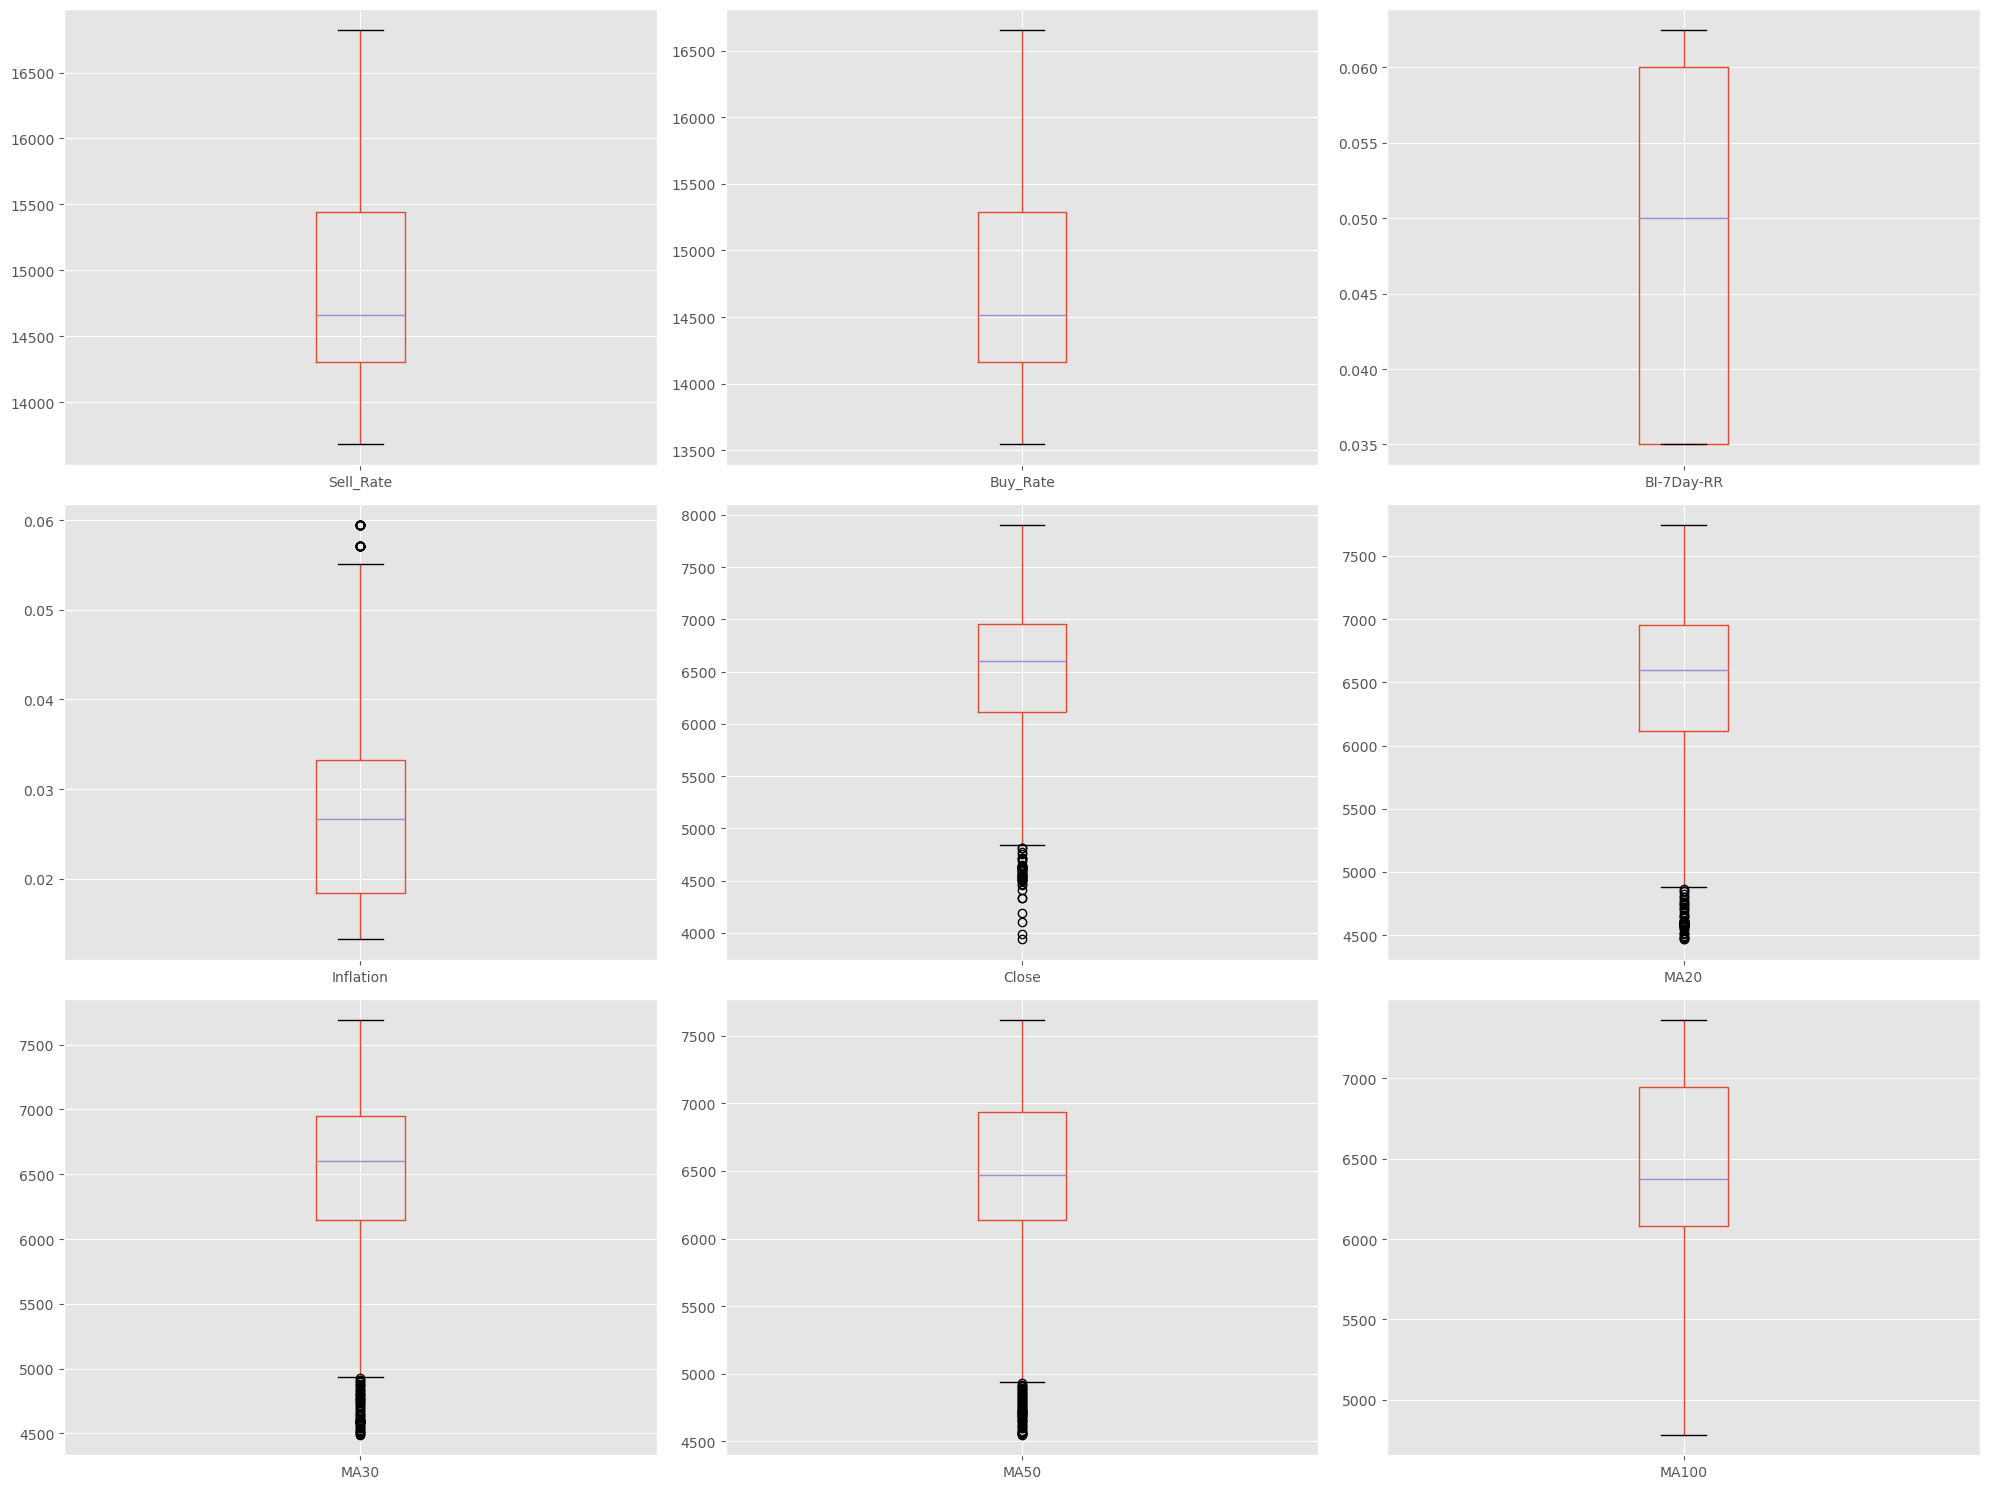

In [171]:
fig, axs = plt.subplots(3, 3, figsize = (20, 15), layout="constrained")

for i,el in enumerate(list(merged.columns.values)[:-1]):
    a = merged.boxplot(el, ax=axs.flatten()[i])

plt.tight_layout() 
plt.show()

## Modelling

In this section, we will try XGBoost Regression to identify which factor affect the Closing price the most

In [173]:
train = merged[merged.index < pd.to_datetime('2024-09-01')]
validation = merged[merged.index >= pd.to_datetime('2024-09-01')]

In [175]:
from sklearn.model_selection import train_test_split

X = train.drop(['Close'], axis=1)
y = train['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_val = validation.drop(['Close'], axis=1)
y_val = validation['Close']

In [177]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [187]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

xgboost_model = xgb.XGBRegressor(
    objective ='reg:squarederror',  # Regression task
    learning_rate=0.3,              # Step size shrinkage
    n_estimators=100,               # Number of trees (boosting rounds)
    max_depth=6,                    # Max depth of trees
    random_state=42
)

xgboost_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [189]:
# Predict on test data
y_pred = xgboost_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 82.2164311288062


In [199]:
print(f"The min price is Rp{round(merged['Close'].min())}")
print(f"The max price is Rp{round(merged['Close'].max())}")
max_min_diff = (merged['Close'].max()-merged['Close'].min())
print(f"Then with a range of Rp{round(max_min_diff)}, having a RMSE of Rp{round(rmse)} is very small, only {round(rmse/(max_min_diff), 2)*100}%")

The min price is Rp3938
The max price is Rp7905
Then with a range of Rp3968, having a RMSE of Rp82 is very small, only 2.0%


In [201]:
# Get feature importances
importance = xgboost_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

      Feature  Importance
4        MA20    0.738795
2  BI-7Day-RR    0.182431
3   Inflation    0.028016
7       MA100    0.017304
5        MA30    0.008480
8       MA200    0.008020
0   Sell_Rate    0.006776
6        MA50    0.005672
1    Buy_Rate    0.004506


<BarContainer object of 9 artists>

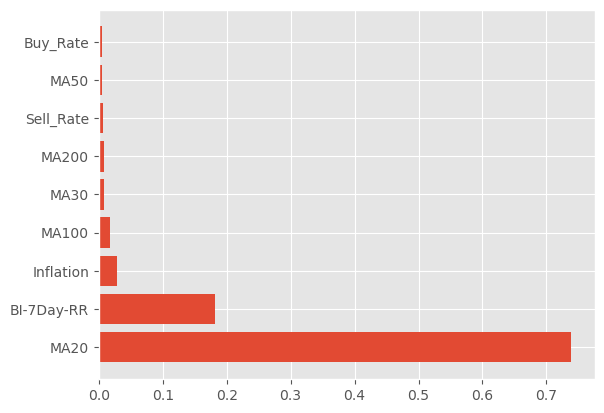

In [213]:
fig, ax = plt.subplots()
ax.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])

In [237]:
#The result shows that MA20 plays a huge important role in the regression for over 70%, while BI Rate follows second at 18%. Let's try to regress only with the Macroeconomic features!

In [227]:
macro_feat = ['Sell_Rate', 'Buy_Rate', 'BI-7Day-RR', 'Inflation']
X_train2 = X_train[macro_feat]
X_test2 = X_test[macro_feat]
X_train_scaled2 = scaler.fit_transform(X_train2)
X_test_scaled2 = scaler.fit_transform(X_test2)
xgboost_model.fit(X_train_scaled2, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [235]:
# Predict on test data
y_pred2 = xgboost_model.predict(X_test_scaled2)

# Evaluate the model
mse2 = mean_squared_error(y_test, y_pred2)
rmse2 = np.sqrt(mse2)

print(f"Root Mean Squared Error: {rmse2}")

Root Mean Squared Error: 336.30076410137445


In [231]:
# Get feature importances
importance = xgboost_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train2.columns,
    'Importance': importance
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

      Feature  Importance
2  BI-7Day-RR    0.669645
3   Inflation    0.287398
0   Sell_Rate    0.040866
1    Buy_Rate    0.002091


In [241]:
#Turns out the RMSE in the second model is higher, thus the first model is better. Let's see how it performs using the validation data.

In [245]:
X_val2 = X_val[macro_feat]
X_val_scaled2 = scaler.fit_transform(X_val2)

# Predict on validation data
val_pred = xgboost_model.predict(X_val_scaled2)

# Evaluate the model
mse = mean_squared_error(y_val, val_pred)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 1246.06793164371


Since the validation data is a time-series entry, containing data from October 2024, the model is unable to predict precisely since XGBoost does not handle trends and seasonality well. We will need a better approach to handle those, namely a time series model.